## Genre Classification : MFCC Features with CNN  

In [11]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import itertools

In [12]:
%cd projet

[Errno 2] No such file or directory: 'projet'
/home/phillyflingo/Desktop/ECM/M2 IAAA/temps2/SAM/projet


In [13]:
import keras

import tensorflow
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, ActivityRegularization, Lambda, BatchNormalization
from keras.layers import Convolution2D, MaxPooling2D, Conv1D, MaxPooling1D
from keras.layers import AveragePooling2D, Input
from keras import backend as K 
from sklearn.preprocessing import OneHotEncoder,LabelEncoder

import os
import glob
import time

import sklearn
from sklearn.preprocessing import normalize

from keras.applications.vgg19 import VGG19
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image
from keras.applications.vgg19 import preprocess_input
from keras.models import Model
from keras.utils import * 

In [14]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

_msdi_path = 'msdi'  # Change this to configure your path to MSDI dataset


def get_msdi_dataframe(msdi_path=_msdi_path):
    return pd.read_csv(Path(msdi_path) / 'msdi_mapping.csv')


def load_mfcc(entry, msdi_path=_msdi_path):
    x = np.load(Path(msdi_path) / entry['mfcc'])
    return x[entry['msd_track_id']]


def load_img(entry, msdi_path=_msdi_path):
    return plt.imread(Path(msdi_path) / entry['img'])


def load_deep_audio_features(entry, msdi_path=_msdi_path):
    subset_file = 'X_{}_audio_MSD-I.npy'.format(entry['set'])
    x = np.load(Path(msdi_path) / 'deep_features' / subset_file, mmap_mode='r')
    idx = entry['deep_features']
    return x[idx, :]


def get_set(entry):
    return entry['set']


def get_label(entry):
    return entry['genre']


def get_label_list(msdi_path=_msdi_path):
    df = pd.read_csv(Path(msdi_path) / 'labels.csv', header=None)
    return list(df.iloc[:, 0])

In [15]:
if __name__ == '__main__':
    # Exemple d'utilisation
    msdi = get_msdi_dataframe(_msdi_path)
    print('Dataset with {} entries'.format(len(msdi)))
    print('#' * 80)
    print('Labels:', get_label_list())
    print('#' * 80)

    entry_idx = 10
    one_entry = msdi.loc[entry_idx]
    print('Entry {}:'.format(entry_idx))
    print(one_entry)
    print('#' * 80)
    mfcc = load_mfcc(one_entry, _msdi_path)
    print('MFCC shape:', mfcc.shape)
    img = load_img(one_entry, _msdi_path)
    print('Image shape:', img.shape)
    deep_features = load_deep_audio_features(one_entry, _msdi_path)
    print('Deep features:', deep_features.shape)
    print('Set:', get_set(one_entry))
    print('Genre:', get_label(one_entry))

Dataset with 30712 entries
################################################################################
Labels: ['Blues', 'Country', 'Electronic', 'Folk', 'Jazz', 'Latin', 'Metal', 'New Age', 'Pop', 'Punk', 'Rap', 'Reggae', 'RnB', 'Rock', 'World']
################################################################################
Entry 10:
Unnamed: 0                                                      10
msd_track_id                                    TRHDZSB128F429112F
genre                                                        Metal
album_index                                                     13
set                                                          train
msd_artist_id                                   ARZN98V1187B990D1D
image_url        http://artwork-cdn.7static.com/static/img/slee...
img                                         img/0000848765_200.jpg
mfcc                                               mfcc/mfcc_H.npz
deep_features                                         

In [8]:
import gc


In [9]:
def get_X_y(msdi_path):
    X_train = []
    y_train = []
    X_test = []
    y_test = []
    mfccs_lenghts = []
    cpt = 0
    msdi = get_msdi_dataframe(msdi_path)
    n = len(msdi)
    
    for idx in range(n):
        entry = msdi.loc[idx]
        cpt+=1
        if  get_set(entry) =='train' :
            print(cpt)
            x = load_mfcc(entry, msdi_path)
            X_train.append(x)
            x=None            
            y = get_label(entry)
            y_train.append(y)
        if  get_set(entry) =='test' :
            print(cpt)
            x = load_mfcc(entry, msdi_path)
            X_test.append(x)
            x=None            
            y = get_label(entry)
            y_test.append(y)
    print('end')
    X_test = np.array(X_test,dtype=object)
    y_test = np.array(y_test)
    X_train = np.array(X_train,dtype=object)
    y_train = np.array(y_train)    
    return X_train,y_train,X_test,y_test
_msdi_path = 'msdi/'  # Change this to configure your path to MSDI dataset
            


In [ ]:
X_train,y_train,X_test,y_test = get_X_y(_msdi_path)

In [34]:
"""X_train = np.load('X_train_img_trunc_1024.npy',allow_pickle=True)
y_train = np.load('y_train_img_trunc_1024.npy')
X_test = np.load('X_test_img_trunc_1024.npy',allow_pickle=True)
y_test = np.load('y_test_img_trunc_1024.npy')"""

In [16]:
"""X_train = np.load('X_train_img_run1.npy',allow_pickle=True)
y_train = np.load('y_train_img_run1.npy')
X_test = np.load('X_test_img_run1.npy',allow_pickle=True)
y_test = np.load('y_test_img_run1.npy')"""

In [9]:
def prepare_targets(y_train, y_test):
    le = LabelEncoder()
    le.fit(y_train)
    le.fit(y_test)
    y_train_enc = le.transform(y_train)
    y_test_enc = le.transform(y_test)
    return y_train_enc,y_test_enc

In [53]:
def truncate_and_delete_short_samples(X,y, max_length):
    """
    truncate the arrays to a fixed length and delete the short samples
    """
    truncated_list_of_arrays = []
    labels=[]
    for i,array in enumerate(X):
        if array.shape[0] > max_length:
            truncated_list_of_arrays.append(array[:max_length])
            array = None
            labels.append(y[i])

    truncated_list_of_arrays = np.array(truncated_list_of_arrays,dtype=object)
    labels= np.array(labels)
    print(truncated_list_of_arrays.shape)
    return truncated_list_of_arrays,labels

In [54]:
X_train,y_train = truncate_and_delete_short_samples(X_train,y_train, max_length=1024)

X_test,y_test = truncate_and_delete_short_samples(X_test,y_test, max_length=1024)
print(X_test.shape,y_test.shape)

(6572, 1024, 12)
(1381, 1024, 12)
(1381, 1024, 12) (1381,)


In [55]:
np.save('X_train_img_trunc_1024.npy',X_train)
np.save('y_train_img_trunc_1024.npy',y_train)
np.save('X_test_img_trunc_1024.npy',X_test)
np.save('y_test_img_trunc_1024.npy',y_test)

In [35]:
X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)

In [36]:
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2], 1)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2], 1)
X_train.shape


(6572, 12288, 1)

In [15]:
#y_train, y_test = prepare_targets(y_train, y_test)

In [37]:
from sklearn.preprocessing import LabelEncoder,OneHotEncoder

labelencoder = LabelEncoder()

labelencoder.fit(y_train)
labelencoder.fit(y_test)


y_train = labelencoder.transform(y_train)
y_test = labelencoder.transform(y_test)

In [38]:
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

In [32]:
from keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator()


In [39]:

input_shape = (X_train.shape[1], 1)
input_shape
# Layer 1
model = Sequential()
model.add(Conv1D(64, 1, activation='relu', input_shape=input_shape))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 1, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(15, activation='softmax'))

opt = tensorflow.keras.optimizers.Adam(learning_rate=0.0001)

# compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt)

# fit the model
history = model.fit(X_train, y_train,validation_data=(X_test, y_test) , epochs=60, batch_size=16,shuffle=True, verbose=1)

Epoch 1/60
411/411 [==============================] - 8s 16ms/step - loss: 3.8513 - val_loss: 2.6867
Epoch 2/60
411/411 [==============================] - 6s 15ms/step - loss: 2.6759 - val_loss: 2.6614
Epoch 3/60
411/411 [==============================] - 6s 15ms/step - loss: 2.6520 - val_loss: 2.6364
Epoch 4/60
411/411 [==============================] - 6s 15ms/step - loss: 2.6287 - val_loss: 2.6122
Epoch 5/60
411/411 [==============================] - 6s 15ms/step - loss: 2.6060 - val_loss: 2.5885
Epoch 6/60
411/411 [==============================] - 6s 15ms/step - loss: 2.5841 - val_loss: 2.5659
Epoch 7/60
411/411 [==============================] - 6s 15ms/step - loss: 2.5630 - val_loss: 2.5439
Epoch 8/60
411/411 [==============================] - 6s 16ms/step - loss: 2.5427 - val_loss: 2.5228
Epoch 9/60
411/411 [==============================] - 6s 16ms/step - loss: 2.5232 - val_loss: 2.5024
Epoch 10/60
411/411 [==============================] - 6s 15ms/step - loss: 2.5044 - val_lo

In [42]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
def evaluate_model(model, X_test, y_test):
    """
    evaluate a model using different metrics for multiclass classification
    :param model: model to be evaluated
    :param X_test: test data
    :param y_test: test labels
    :return: a table of different metrics for multiclass classification
    """
    # predict classes
    y_pred = model.predict(X_test)

    y_pred=np.argmax(y_pred,axis=1)
    # calculate precision score
    precision = precision_score(y_test, y_pred, average='micro')
    # calculate recall score
    recall = recall_score(y_test, y_pred, average='micro')
    # calculate f1 score
    f1 = f1_score(y_test, y_pred, average='micro')
    # calculate accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    # create a dictionary of metrics
    metrics = {'precision': precision, 'recall': recall, 'f1': f1, 'accuracy': accuracy}
    # create a dataframe of metrics
    df = pd.DataFrame(metrics, index=[0])
    # return the dataframe
    return df


In [43]:
evaluate_model(model, X_test, y_test)

,precision,recall,f1,accuracy
0,0.33092,0.33092,0.33092,0.33092


In [45]:
model.save('model_mcff_1024_60')

INFO:tensorflow:Assets written to: model_mcff_1024_60/assets


In [46]:
import matplotlib.pyplot as plt

def plot_loss(fit_history,title):
  plt.plot(fit_history.history['loss'])
  plt.plot(fit_history.history['val_loss'])
  plt.title(title)
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'], loc='upper left')
  plt.show()

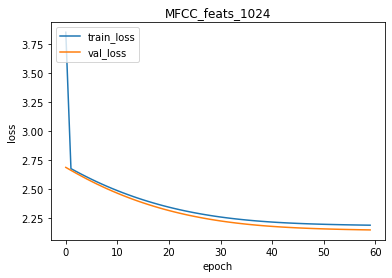

In [47]:
plot_loss(history,'MFCC_feats_1024')

In [ ]:
def plot_confusion_matrix(y_true, y_pred, labels):
    """
    plots the confusion matrix
    """
    matrix = confusion_matrix(y_true, y_pred)    
    fig, ax = plt.subplots(figsize=(12,10))
    plt.imshow(matrix)
    ax.set_xticks(range(len(labels)));
    ax.set_xticklabels(labels, rotation=0)
    ax.set_yticks(range(len(labels)));
    ax.set_yticklabels(labels)
    max_confusions = 0
    confused_classes = (-1, -1)
    for i, true_label in enumerate(matrix):
        for j, predicted_label in enumerate(true_label):
            text = ax.text(j, i, matrix[i, j],
                        ha="center", va="center", color="w");
    plt.tick_params(axis=u'both', which=u'both',length=0)
    plt.title("Confusion Matrix")

In [ ]:
"""X_train = np.asarray(X_train).astype(np.float32)
#y_train = np.asarray(y_train).astype(np.float32)
X_test = np.asarray(X_train).astype(np.float32)
#y_test = np.asarray(y_train).astype(np.float32)"""

In [ ]:
"""# reshape data to fit model
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# one hot encode target values
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
"""